# Predicting Wind Turbine Output with a Random Forest

In this analysis, the shape of the data frame is taken directly from the original data file: each record contains measurements from a single zone, even though the power output from the wind turbine in that zone is correlated with wind velocity measurements in other zones.

1. [Imports.](#Cell1)
1. [Data preprocessing function for training and testing data sets.](#Cell2)
1. [Preprocess training data set and split it into training and testing subsets.](#Cell3)
1. [Fit random forest model to training subset of training data set.](#Cell4)
1. [Do a grid search to find optimal hyper-parameters of the random forest regressor.](#Cell5)
1. [Retrieve trained model from disk. Only run this cell if previous one wasn't run.](#Cell6)
1. [Evaluate fit results, histogram feature importances and predicted and actual turbine output.](#Cell7)
1. [Fit random forest model to entire training data set.](#Cell8)
1. [Retrieve trained model from disk. Only run this cell if previous one wasn't run.](#Cell8b)
1. [Prepare test data set in the same way as the training set, make predictions, and create output csv file.](#Cell9)
1. [Make a plot of weekly RMSE over training and testing data sets combined.](#Cell10)

<a id='Cell1'></a>

In [1]:
'''
Imports
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
import csv
import datetime
from time import strftime

%matplotlib inline

<a id='Cell2'></a>

In [2]:
'''
Data preprocessing function for training and testing data sets.
'''

def PreProcess(fname, Nroll=3):
    '''
    Read in wind turbine data and store them in a Pandas dataframe after cleanup.
    The input csv file fname contains the following fields:

    ID:         Unique ID for each observation
    ZONEID:     Zone/Turbine ID, a number between 1 and 10
    TIMESTAMP:  Time of observation, in the format "YYYYMMDD h:mm" or "YYYYMMDD hh:mm"
    TARGETVAR:  Wind turbine output
    U10:        Zonal Wind Vector at 10 m
    V10:        Meridional Wind Vector at 10 m
    U100:       Zonal Wind vector at 100 m
    V100:       Meridional Wind vector at 100 m
    '''
    
    # Read in the windmill data, parsing the third column as datetimes.
    Train     = "Train" in fname or "Solution" in fname
    df0       = pd.read_csv(fname, header=0, parse_dates=[2], index_col=2)
    df0.fillna(0, inplace=True)
    # Split data frame according to zone id
    nturbines = 10
    df1       = []
    for iturbine in range(1,nturbines+1):
        df1.append(df0.loc[df0["ZONEID"]==iturbine,:])

    # Compute rolling means of wind speed measurements
    if Nroll>1:
        window = str(Nroll)+"H"
        print('PreProcess: Computing rolling means over {0}.'.format(window))
        dname  = "_rm"+str(Nroll)
        df1new = []
        for df1t in df1:
            df1t.loc[:,"U10"+dname]  = df1t["U10"].rolling(window,  min_periods=1).mean()
            df1t.loc[:,"V10"+dname]  = df1t["V10"].rolling(window,  min_periods=1).mean()
            df1t.loc[:,"U100"+dname] = df1t["U100"].rolling(window, min_periods=1).mean()
            df1t.loc[:,"V100"+dname] = df1t["V100"].rolling(window, min_periods=1).mean()
            df1u = df1t.drop(["U10", "V10", "U100", "V100"], axis=1)
            df1new.append(df1u)
        df2    = pd.concat(df1new)
    else:
        print('PreProcess: No rolling means computed')
        df2    = pd.concat(df1)

    # Put the timestamp index back as a dataframe column
    df2              = df2.reset_index()

    # Extract year, day of year, and hour from timestamp, then drop timestamp column
    df2["Year"]      = df2["TIMESTAMP"].map(lambda x: x.year)
    df2["DayOfYear"] = df2["TIMESTAMP"].map(lambda x: x.timetuple().tm_yday)
    df2["Hour"]      = df2["TIMESTAMP"].map(lambda x: x.hour)
    df2.drop('TIMESTAMP', axis=1, inplace=True)

    # Rename columns
    if Train:
        df2.rename(columns={"ID": "Id", "ZONEID": "ZoneId", "TARGETVAR": "Target"}, inplace=True)
    else:
        df2.rename(columns={"ID": "Id", "ZONEID": "ZoneId"}, inplace=True)

    # One-hot encode categorical variable ZoneId.
    df2['ZoneId'] = df2['ZoneId'].astype(int).astype("category")
    df2           = pd.get_dummies(df2, drop_first=True)

    print('PreProcess: Dataframe Shape = {0}'.format(df2.shape))
    
    return df2

<a id='Cell3'></a>

In [3]:
'''
Preprocess training data set and split it into training and testing subsets.
'''

fname = "Train_full.csv"
rwin  = 3
df0   = PreProcess(fname, Nroll=rwin)

# Convert pandas dataframe to its numpy representation, separating out features from target variable.
features  = df0.columns.values.tolist()
features.remove("Target")
features.remove("Id")
X         = df0.as_matrix(columns=features)
y         = np.array(df0["Target"].tolist())

# Create training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print('Size of data set for training: {0}, for testing: {1}\n'.format(len(y_train), len(y_test)))

PreProcess: Computing rolling means over 3H.


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


PreProcess: Dataframe Shape = (168000, 18)
Size of data set for training: 126000, for testing: 42000



In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168000 entries, 0 to 167999
Data columns (total 18 columns):
Id           168000 non-null int64
Target       168000 non-null float64
U10_rm3      168000 non-null float64
V10_rm3      168000 non-null float64
U100_rm3     168000 non-null float64
V100_rm3     168000 non-null float64
Year         168000 non-null int64
DayOfYear    168000 non-null int64
Hour         168000 non-null int64
ZoneId_2     168000 non-null uint8
ZoneId_3     168000 non-null uint8
ZoneId_4     168000 non-null uint8
ZoneId_5     168000 non-null uint8
ZoneId_6     168000 non-null uint8
ZoneId_7     168000 non-null uint8
ZoneId_8     168000 non-null uint8
ZoneId_9     168000 non-null uint8
ZoneId_10    168000 non-null uint8
dtypes: float64(5), int64(4), uint8(9)
memory usage: 13.0 MB


In [7]:
df0[df0['U10_rm3'].isnull()]

,Id,Target,U10_rm3,V10_rm3,U100_rm3,V100_rm3,Year,DayOfYear,Hour,ZoneId_2,ZoneId_3,ZoneId_4,ZoneId_5,ZoneId_6,ZoneId_7,ZoneId_8,ZoneId_9,ZoneId_10


<a id='Cell4'></a>

In [4]:
'''
Fit random forest model to training subset of training data set.
'''

rfr_train = RandomForestRegressor(n_estimators=2000, criterion="mse", max_depth=40, min_samples_split=2, 
                                  min_samples_leaf=3, max_features="sqrt", max_leaf_nodes=None, bootstrap=True,
                                  oob_score=False, n_jobs=-1, random_state=0, verbose=0)
%time rfr_train.fit(X_train, y_train)

CPU times: user 12min 40s, sys: 7.25 s, total: 12min 47s
Wall time: 3min 21s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [8]:
rfrb = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=4000, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
%time rfrb.fit(X_train, y_train)

CPU times: user 34min 15s, sys: 21.8 s, total: 34min 37s
Wall time: 9min 12s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=4000, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

<a id='Cell5'></a>

In [ ]:
'''
Do a grid search to find optimal hyper-parameters of the random forest regressor.
Use Root Mean Squared Error (RMSE) to score parameter choices.

(This cell can be omitted if the previous one was run.)
'''

# Specify the parameter grid to be searched
parameter_grid = [{'n_estimators': [1000, 2000, 3000], 
                   'max_depth': [30, 40, 50], 
                   'min_samples_leaf': [3, 5, 7]}]

# Start the grid search
rfo = GridSearchCV(RandomForestRegressor(criterion='mse', min_samples_split=2, max_features="sqrt",
                                         max_leaf_nodes=None, bootstrap=True, oob_score=False, 
                                         n_jobs=-1, random_state=0, verbose=0),
                   parameter_grid, refit=True, cv=5, scoring='neg_mean_squared_error')
%time rfo.fit(X_train, y_train)

# Print out the results (flipping the sign on the grid scores to make them positive again).
print("Best parameter values found on development set:")
print(" ")
print(rfo.best_params_)
print(" ")
print("Grid scores on development set:")
print(" ")
for mean_score, std_score, settings in zip(rfo.cv_results_['mean_test_score'], 
                                           rfo.cv_results_['std_test_score'],
                                           rfo.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" %(-mean_score, 2*std_score, settings))

# Retrieve best random forest model from grid search
rfr_train = rfo.best_estimator_
print("\nBest estimator:\n%s" %rfr_train)

fName = 'rfr_train_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(rfr_train, path_to_file)
print('\nRandom forest regression model saved to {0}'.format(path_to_file))

<a id='Cell6'></a>

In [5]:
'''
Retrieve trained model from disk. Only run this cell if previous one wasn't run.
Note that by default the file name encodes a date and time, to the second.
'''

rfr_found = True

try:
    rfrb
except:
    fName        = 'rfr_train_2017_04_22_04_27_55'
#    fName        = 'rfr_train_2017_04_07_00_31_00'
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        rfr_train = joblib.load(path_to_file)
    except:
        print('Error loading regression model from {0}\n'.format(path_to_file))
        rfr_found = False
    else:
        print('Regression model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Fitted model already exists, not updated from file!\n')

if rfr_found:
    print("Estimator:\n\n%s\n" %rfr_best)

Regression model successfully loaded from fitted_models/rfr_train_2017_04_22_04_27_55.model

Estimator:

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3000, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)



<a id='Cell7'></a>

In [9]:
'''
Evaluate fit results.
'''

# Plot feature importances, sorted in decreasing order
#importances = rfr_train.feature_importances_
#indices     = np.argsort(importances)[::-1]
#n_features  = indices.size
#bins        = np.arange(n_features)
#x_labels    = np.array(features)[indices][:n_features]
#maxHeight   = 1.10*max(importances)
#fig, axes   = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
#axes.bar(bins, importances[indices][:n_features], align="center", color="lightblue", edgecolor="k", alpha=0.5)
#axes.set_xlabel("Feature", fontsize=15)
#axes.set_xticks(bins)
#axes.set_xticklabels(x_labels, ha="right", rotation=45., fontsize=15)
#axes.set_xlim([-0.5,bins.size-0.5])
#axes.set_ylabel("Importance", fontsize=15)
#axes.set_ylim([0.0, maxHeight])
#rfr_parameters = rfr_train.get_params()
#mx_dpth = rfr_parameters['max_depth']
#mn_s_lf = rfr_parameters['min_samples_leaf']
#n_trees = rfr_parameters['n_estimators']
#axes.text(0.45, 0.92, 
#          'Max. depth: {0}, Min. samples/leaf: {1}, Number of trees: {2}'.format(mx_dpth,mn_s_lf,n_trees),
#          fontsize=15, transform=axes.transAxes)
#plt.show()
#fig.savefig('rfr16_feature_importances.png', dpi=200, bbox_inches='tight')

# Compute root mean squared errors on train and test sets.
y_train_pred = rfrb.predict(X_train)
y_test_pred  = rfrb.predict(X_test)
rmse_train   = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test    = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('\nRMSE on train data set: {0}'.format(rmse_train))
print('RMSE on test data set:  {0}'.format(rmse_test))


RMSE on train data set: 0.09306089564648702
RMSE on test data set:  0.13904669677084652


In [10]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print('\nMAE on train data set: {0}'.format(mae_train))
print('MAE on test data set:  {0}'.format(mae_test))


MAE on train data set: 0.06483154672343179
MAE on test data set:  0.09875146895768679


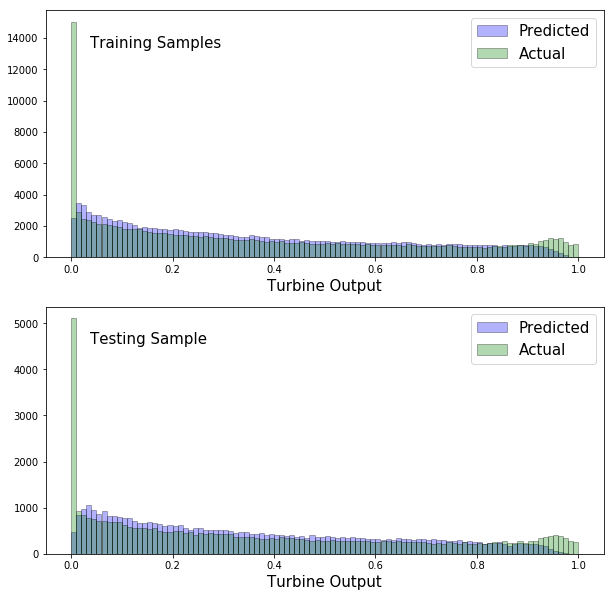

In [28]:
'''
Make a histogram of the actual and predicted response variable in the training set.
'''
  
actual_targets_train    = y_train
predicted_targets_train = rfrb.predict(X_train)
actual_targets_test     = y_test
predicted_targets_test  = rfrb.predict(X_test)
    
fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(10,10) )
axis[0].hist(predicted_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='Predicted')
axis[0].hist(actual_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='Actual')
axis[0].set_xlabel("Turbine Output", fontsize=15)
axis[0].legend(prop={'size': 15},loc="upper right")
axis[0].text(0.08, 0.85, "Training Samples", fontsize=15, transform=axis[0].transAxes)

axis[1].hist(predicted_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='Predicted')
axis[1].hist(actual_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='Actual')
axis[1].set_xlabel("Turbine Output", fontsize=15)
axis[1].legend(prop={'size': 15},loc="upper right")
axis[1].text(0.08, 0.85, "Testing Sample", fontsize=15, transform=axis[1].transAxes)

plt.show()


<a id='Cell8'></a>

In [10]:
'''
Fit random forest model to entire training data set.
'''
settings = rfr_train.get_params()
rfr      = RandomForestRegressor(**settings)
%time rfr.fit(X, y)

fName = 'rfr16_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(rfr, path_to_file)
print('\nRandom forest regression model saved to {0}'.format(path_to_file))

CPU times: user 22min 14s, sys: 16.7 s, total: 22min 30s
Wall time: 6min 19s

Random forest regression model saved to fitted_models/rfr16_2017_04_23_21_09_23.model


<a id='Cell8b'></a>

In [11]:
'''
Retrieve trained model from disk. Only run this cell if previous one wasn't run.
Note that by default the file name encodes a date and time, to the second.
'''

rfr_found = True

try:
    rfr
except:
    fName = 'rfr16_2017_04_23_21_09_23' # rm=3
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        rfr = joblib.load(path_to_file)
    except:
        print('Error loading regression model from {0}\n'.format(path_to_file))
        rfr_found = False
    else:
        print('Regression model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Fitted model already exists, not updated from file!\n')

if rfr_found:
    print("Estimator:\n\n%s\n" %rfr)

Fitted model already exists, not updated from file!

Estimator:

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3000, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)



<a id='Cell9'></a>

In [9]:
'''
Prepare test data set in the same way as the training set, make predictions, and create output csv file.
'''

# Preprocess testing data set.
fname       = "data/Test_uP7dymh.csv"
ttdf0       = PreProcess(fname, Nroll=rwin)

# Save Id column to list.
ttid        = ttdf0['Id'].tolist()

# Count how many observations we have in August and September 2013
nTotal      = len(ttdf0)
nAugSep2013 = len([DoY for DoY in ttdf0['DayOfYear'] if DoY>212 and DoY<274])
print('\nTotal number of observation times in test set:       {0}'.format(nTotal))
print('Number of observations in August and September 2013: {0}'.format(nAugSep2013))

# Compute predictions for test set.
ttX         = ttdf0.as_matrix(columns=features)
tty         = rfr.predict(ttX)

# Generate output csv file
fName_out   = 'data/rfr_' + strftime("%Y_%m_%d_%H_%M_%S") + '.out.csv'
with open(fName_out, 'w') as csvfile:
    writer  = csv.writer(csvfile)
    writer.writerow(["ID", "TARGETVAR"])
    for idval,yval in zip(ttid,tty):
        writer.writerow([idval,yval])
print('\nOutput written to {0}'.format(fName_out))

PreProcess: Computing rolling means over 3H.
PreProcess: Dataframe Shape = (29290, 17)

Total number of observation times in test set:       29290
Number of observations in August and September 2013: 14640

Output written to data/rfr_2017_04_22_10_58_06.out.csv


<a id='Cell10'></a>

PreProcess: Computing rolling means over 3H.
PreProcess: Dataframe Shape = (29290, 18)

Shape of final, combined training+solution data frame: (16800, 61)

Number of rmse data points: 100


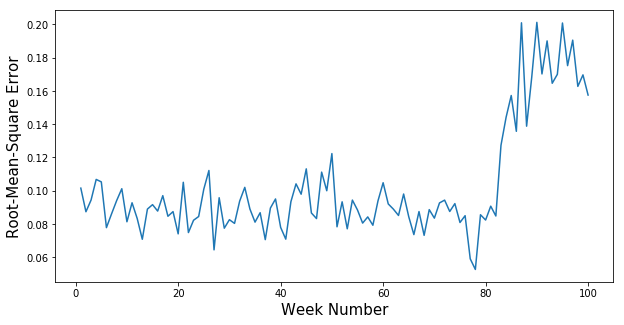

In [36]:
'''
Make a plot of weekly RMSE over training and testing data sets combined.
Assume we ran the first three cells of this notebook, so that df0 already contains the training data.
Also assume that the fully trained model rfr is available.
'''
'''
# Process solution data file.
SolutionDataFile = "data/Solution.csv"
df2              = PreProcess(SolutionDataFile, Nroll=rwin)
'''
# Concatenate the training and solution data frames.
df3 = pd.concat([df0, df2])

# Make predictions
df3['Prediction'] = rfr.predict(df3[features])

# Reverse one-hot encoding
zoneIds = ["ZoneId_"+str(ind) for ind in range(2,11)]
def get_zoneid(row):
    codes   = [row[zoneId] for zoneId in zoneIds]
    try:
        ZID = codes.index(1) + 2
    except:
        ZID = 1
    return ZID

df3['ZoneId'] = df3.apply(get_zoneid, axis=1)
df3.drop(zoneIds, axis=1, inplace=True)

# Create timestamp column and use it to create a multi-index with ZoneId
def ydh_to_dt(row):
    year      = int(row['Year'])
    dayofyear = int(row['DayOfYear'])
    hour      = int(row['Hour'])
    return datetime.datetime(year, 1, 1, hour) + datetime.timedelta(dayofyear - 1)

df3['TimeStamp'] = df3.apply(ydh_to_dt, axis=1)
df3.set_index(['TimeStamp', 'ZoneId'], drop=True, append=False, inplace=True, verify_integrity=True)

# Unstack inner level of multi-index and rename columns
df3.drop(['Id', 'Year', 'DayOfYear', 'Hour'], axis=1, inplace=True)
df4         = df3.unstack()
df4.columns = [item[0]+'_'+str(item[1]) for item in df4.columns.values if item[0]]

# Compute Mean Squared Error on the ten target variables in each row.
df4['MSE'] = sum([(df4['Target_'+str(ind)]-df4['Prediction_'+str(ind)])**2 for ind in range(1,11)])/10.0

print('\nShape of final, combined training+solution data frame: {0}'.format(df4.shape))

# Compute weekly rmse.
datetime0 = df4.index[0]
rmse      = np.sqrt(df4.groupby((df4.index-datetime0).days/7).MSE.mean())
npts      = len(rmse)
print('\nNumber of rmse data points: {0}'.format(npts))

# Save weekly rmse to file
with open('data/rfr16_weekly_rmse.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(rmse)

# Make plot
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
axis.plot(range(1,101), rmse )
axis.set_xlabel("Week Number", fontsize=15)
axis.set_ylabel("Root-Mean-Square Error", fontsize=15)
axis.set_ylim(0.0, 0.225)
plt.show()
fig.savefig('rfr16_weekly_rmse.png', dpi=200, bbox_inches='tight')

In [ ]:
from sklearn.svm import SVR

clflr = SVR(kernel = 'rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

%time clflr.fit(X_train, y_train)




y_train_pred = clflr.predict(X_train)
y_test_pred  = clflr.predict(X_test)
rmse_train   = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test    = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('\nRMSE on train data set: {0}'.format(rmse_train))
print('RMSE on test data set:  {0}'.format(rmse_test))




#actual_targets_train    = y_train
#predicted_targets_train = clf.predict(X_train)
#actual_targets_test     = y_test
#predicted_targets_test  = clf.predict(X_test)
    
    
#fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(10,10) )
#axis[0].hist(predicted_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
#             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='Predicted')
#axis[0].hist(actual_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
#             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='Actual')
#axis[0].set_xlabel("Turbine Output", fontsize=15)
#axis[0].legend(prop={'size': 15},loc="upper right")
#axis[0].text(0.08, 0.85, "Training Samples", fontsize=15, transform=axis[0].transAxes)

#axis[1].hist(predicted_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
#             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='Predicted')
#axis[1].hist(actual_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
#             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='Actual')
#axis[1].set_xlabel("Turbine Output", fontsize=15)
#axis[1].legend(prop={'size': 15},loc="upper right")
#axis[1].text(0.08, 0.85, "Testing Sample", fontsize=15, transform=axis[1].transAxes)

#plt.show()


CPU times: user 322 ms, sys: 65.1 ms, total: 387 ms
Wall time: 529 ms

RMSE on train data set: 0.11071658965139415
RMSE on test data set:  0.1418622266466578

MAE on train data set: 0.07524561797830207
MAE on test data set:  0.09802674712011429


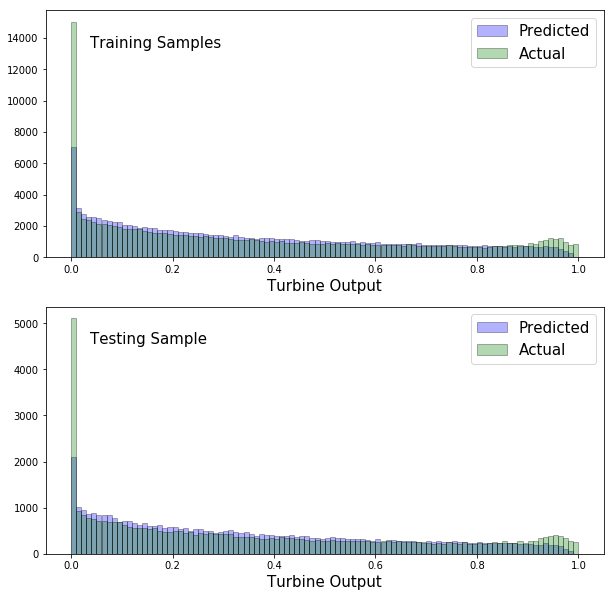

In [11]:
from sklearn.neighbors import KNeighborsRegressor

knnr = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=50, p=2, metric='minkowski', metric_params=None)

%time knnr.fit(X_train, y_train)

y_train_pred = knnr.predict(X_train)
y_test_pred  = knnr.predict(X_test)
rmse_train   = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test    = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('\nRMSE on train data set: {0}'.format(rmse_train))
print('RMSE on test data set:  {0}'.format(rmse_test))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print('\nMAE on train data set: {0}'.format(mae_train))
print('MAE on test data set:  {0}'.format(mae_test))

actual_targets_train    = y_train
predicted_targets_train = knnr.predict(X_train)
actual_targets_test     = y_test
predicted_targets_test  = knnr.predict(X_test)
   
    
fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(10,10) )
axis[0].hist(predicted_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='Predicted')
axis[0].hist(actual_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='Actual')
axis[0].set_xlabel("Turbine Output", fontsize=15)
axis[0].legend(prop={'size': 15},loc="upper right")
axis[0].text(0.08, 0.85, "Training Samples", fontsize=15, transform=axis[0].transAxes)

axis[1].hist(predicted_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='Predicted')
axis[1].hist(actual_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='Actual')
axis[1].set_xlabel("Turbine Output", fontsize=15)
axis[1].legend(prop={'size': 15},loc="upper right")
axis[1].text(0.08, 0.85, "Testing Sample", fontsize=15, transform=axis[1].transAxes)
plt.show()

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

clfqn = GradientBoostingRegressor(loss='quantile',
                                n_estimators=500, max_depth=4,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

%time clfqn.fit(X_train, y_train)

y_train_pred1 = clfqn.predict(X_train)
y_test_pred1  = clfqn.predict(X_test)
rmse_train   = np.sqrt(mean_squared_error(y_train, y_train_pred1))
rmse_test    = np.sqrt(mean_squared_error(y_test, y_test_pred1))
print('\nRMSE on train data set: {0}'.format(rmse_train))
print('RMSE on test data set:  {0}'.format(rmse_test))



mae_train = mean_absolute_error(y_train, y_train_pred1)
mae_test = mean_absolute_error(y_test, y_test_pred1)
print('\nMAE on train data set: {0}'.format(mae_train))
print('MAE on test data set:  {0}'.format(mae_test))


CPU times: user 2min 26s, sys: 1.15 s, total: 2min 28s
Wall time: 2min 29s

RMSE on train data set: 0.24701305699139778
RMSE on test data set:  0.24799007557943756


NameError: name 'mean_absolute_error' is not defined

In [5]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train, y_train_pred1)
mae_test = mean_absolute_error(y_test, y_test_pred1)
print('\nMAE on train data set: {0}'.format(mae_train))
print('MAE on test data set:  {0}'.format(mae_test))
mae_train = mean_absolute_error(y_train, y_train_pred1)
mae_train = mean_abosulte_error(y_test, y_test_pred1)


MAE on train data set: 0.19397771586410884
MAE on test data set:  0.1958911860387888


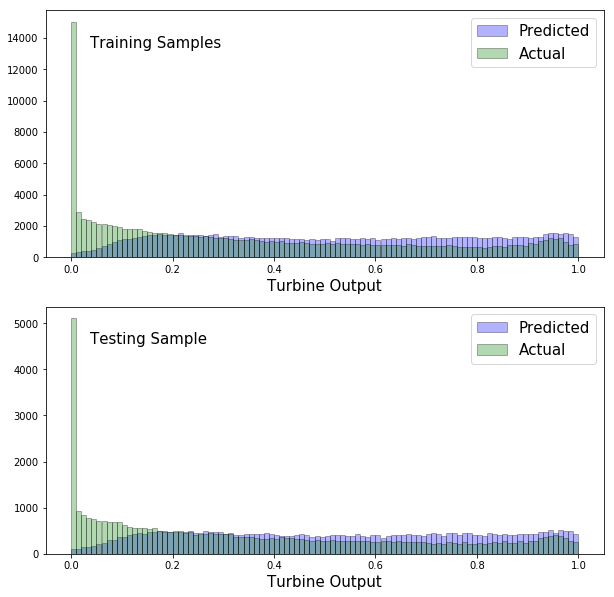

In [51]:
actual_targets_train    = y_train
predicted_targets_train = clfq.predict(X_train)
actual_targets_test     = y_test
predicted_targets_test  = clfq.predict(X_test)
   
    
fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(10,10) )
axis[0].hist(predicted_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='Predicted')
axis[0].hist(actual_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='Actual')
axis[0].set_xlabel("Turbine Output", fontsize=15)
axis[0].legend(prop={'size': 15},loc="upper right")
axis[0].text(0.08, 0.85, "Training Samples", fontsize=15, transform=axis[0].transAxes)

axis[1].hist(predicted_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='Predicted')
axis[1].hist(actual_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='Actual')
axis[1].set_xlabel("Turbine Output", fontsize=15)
axis[1].legend(prop={'size': 15},loc="upper right")
axis[1].text(0.08, 0.85, "Testing Sample", fontsize=15, transform=axis[1].transAxes)
plt.show()

In [44]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(activation='relu', alpha=1e-08, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-10, hidden_layer_sizes=(10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=350, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

%time mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
y_test_pred  = mlp.predict(X_test)
rmse_train   = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test    = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('\nRMSE on train data set: {0}'.format(rmse_train))
print('RMSE on test data set:  {0}'.format(rmse_test))

CPU times: user 18 s, sys: 8.25 s, total: 26.2 s
Wall time: 16.1 s

RMSE on train data set: 0.29595629395672557
RMSE on test data set:  0.2951884614402923


In [13]:
from sklearn.ensemble import GradientBoostingRegressor

gbc = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=4, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
%time gbc.fit(X_train, y_train)



CPU times: user 33.2 s, sys: 199 ms, total: 33.4 s
Wall time: 33.7 s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [14]:

y_train_pred = gbc.predict(X_train)
y_test_pred  = gbc.predict(X_test)
rmse_train   = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test    = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('\nRMSE on train data set: {0}'.format(rmse_train))
print('RMSE on test data set:  {0}'.format(rmse_test))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print('\nMAE on train data set: {0}'.format(mae_train))
print('MAE on test data set:  {0}'.format(mae_test))


RMSE on train data set: 0.1608931303791007
RMSE on test data set:  0.1616349631089966

MAE on train data set: 0.11793307678151183
MAE on test data set:  0.11852977870338724


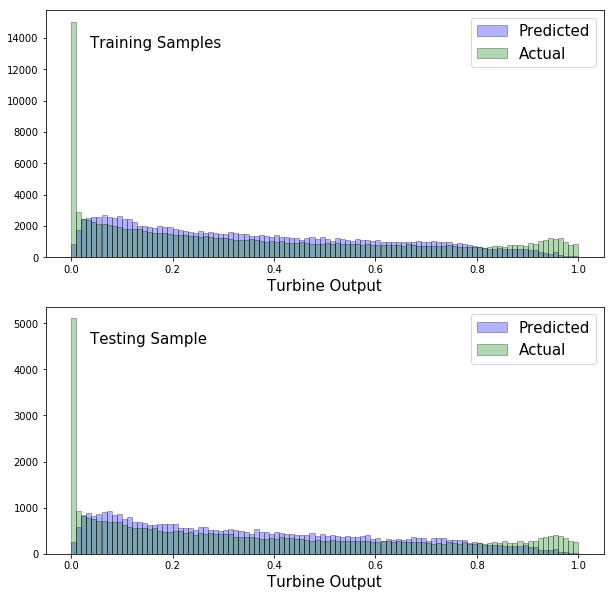

In [52]:
actual_targets_train    = y_train
predicted_targets_train = gbc.predict(X_train)
actual_targets_test     = y_test
predicted_targets_test  = gbc.predict(X_test)
   
    
fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(10,10) )
axis[0].hist(predicted_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='Predicted')
axis[0].hist(actual_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='Actual')
axis[0].set_xlabel("Turbine Output", fontsize=15)
axis[0].legend(prop={'size': 15},loc="upper right")
axis[0].text(0.08, 0.85, "Training Samples", fontsize=15, transform=axis[0].transAxes)

axis[1].hist(predicted_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='Predicted')
axis[1].hist(actual_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='Actual')
axis[1].set_xlabel("Turbine Output", fontsize=15)
axis[1].legend(prop={'size': 15},loc="upper right")
axis[1].text(0.08, 0.85, "Testing Sample", fontsize=15, transform=axis[1].transAxes)
plt.show()

In [60]:
from sklearn.ensemble import AdaBoostRegressor
abr = AdaBoostRegressor(n_estimators=100, learning_rate=1, loss='linear', random_state=None)

%time abr.fit(X_train, y_train)

y_train_pred = abr.predict(X_train)
y_test_pred = abr.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test,y_test_pred))
print('\nRMSE on train data set: {0}'.format(rmse_train))
print('RMSE on test data set:  {0}'.format(rmse_test))

CPU times: user 11.3 s, sys: 146 ms, total: 11.5 s
Wall time: 11.7 s

RMSE on train data set: 0.2363906078958684
RMSE on test data set:  0.23610153641266127
